Notebook to generate plots and data for the [data story](https://andreaslp.github.io/APA-DataStory/). 

In [1]:
# Built-in
import os
from IPython.display import display
from PIL import Image

# Third parties
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, get_single_color_func
import nltk
from nltk import tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

plt.style.use("seaborn")

In [3]:
# Configuration
DATA_PATH = "../data"
PKL_PATH = os.path.join(DATA_PATH, "pkl")
CSV_PATH = os.path.join(DATA_PATH, "csv")
RESOURCES_PATH = os.path.join(DATA_PATH, "resources")

df = pd.read_pickle(os.path.join(PKL_PATH, "final_subset.pkl"))

### 0. Extract extreme quotes

In [22]:
extreme = df[np.abs(df["compound"]) > 0.7].sample(3)[["speaker", "compound", "quotation"]]

for q in extreme.iterrows():
    print(q[1][0], q[1][1])
    print(q[1][2])
    print("\n")

patrick kennedy 0.9042
it should easily be a bipartisan issue: you win with democrats because you're helping people, and you win with republicans because you're saving taxpayer dollars,


john hickenlooper -0.9081
i think, if you look at president trump, he has divided the country worst than it's ever been divided in its history -- or at least certainly for -- in the last 100 years. you know, my history, both as a mayor, and as a governor, as a businessperson was to bring people together and find solutions to vexing problems. to -- you know, we brought environmentalists together with the oil and gas industry for methane regulations, the equivalent of taking 320,000 cars off the road. we got expanded medicaid. we got almost 95% of the population of colorado now has healthcare coverage. those are difficult, tough problems. we've been able to get people together.


mike bost 0.9832
this new law is vitally important for america's heroes and their families. too many veterans are faced with 

### 1. Overall look

In [4]:
df.groupby("speaker")["quotation"].count().sort_values(ascending=False).head(10)

speaker
president donald trump    10279
donald trump               7853
president trump            5358
hillary clinton            4644
nancy pelosi               4203
elizabeth warren           3217
lindsey graham             1934
adam schiff                1558
harry reid                 1496
mike pence                 1480
Name: quotation, dtype: int64

In [5]:
df.groupby("parties")["quotation"].count().sort_values(ascending=False)

parties
Republican    56257
Democrat      49672
Name: quotation, dtype: int64

In [6]:
df["compound"].mean()

0.0468416580917407

In [7]:
df.groupby("parties")["compound"].mean()

parties
Democrat      0.049648
Republican    0.044364
Name: compound, dtype: float64

In [8]:
# Most positive
df.iloc[df["compound"].argmax()]["speaker"]

'elizabeth warren'

In [9]:
# Most negative
df.iloc[df["compound"].argmin()]["speaker"]

'kevin mccarthy'

In [10]:
df["date"] = pd.to_datetime(df["date"])

# Global average per month
g_all = df.set_index("date").groupby(pd.Grouper(freq="M"))["compound"].mean()
g_ma = g_all.rolling(5, center=True, closed="both").mean()
# Average per party per month
g = pd.DataFrame(df.set_index("date").groupby([pd.Grouper(freq="M"), "parties"])["compound"].mean()).reset_index("parties")
g_dem = g[g["parties"] == "Democrat"]
g_rep = g[g["parties"] == "Republican"]

x = np.arange(0, 1932 + 1, step=1, dtype=int)
y_all = -3.364e-5 * x + 0.0850
y_rep = -4.695e-5 * x + 0.0986
y_dem = -1.800e-5 * x + 0.0697

x_dates = [pd.Timestamp('2015-01-01 00:00:00') + pd.Timedelta(offset, 'D') for offset in x]

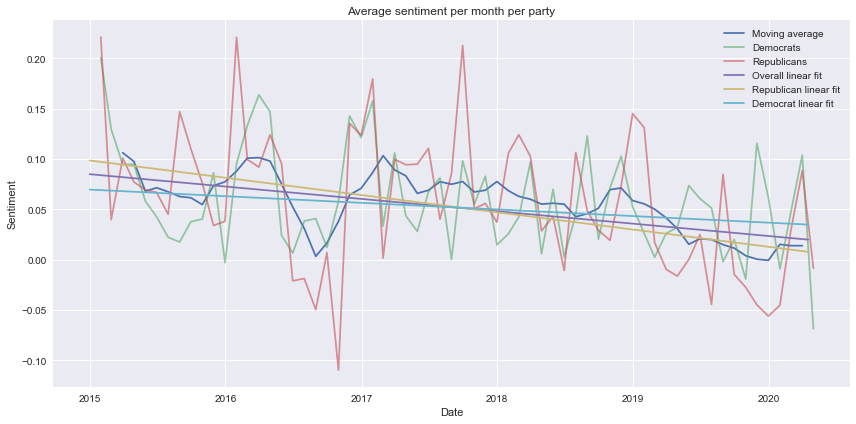

In [19]:
# Plot average score per month and party
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(g_ma.index, g_ma, label="Moving average", alpha=1)
ax.plot(g_dem.index, g_dem["compound"], label="Democrats", alpha=0.6)
ax.plot(g_rep.index, g_rep["compound"], label="Republicans", alpha=0.6)

plt.title("Average sentiment per month per party")
plt.xlabel("Date")
plt.ylabel("Sentiment")

plt.legend()

fname = f"./figures/2.average_month_party.png"
plt.savefig(fname)

ax.plot(x_dates, y_all, label='Overall linear fit')
ax.plot(x_dates, y_rep, label='Republican linear fit')
ax.plot(x_dates, y_dem, label='Democrat linear fit')

plt.legend()
fig.tight_layout()

fname = f"./figures/3.3.average_month_party_with_linear_fits.png"
plt.savefig(fname)

plt.show() 

### 3. Impact of key events

In [12]:
events = pd.read_csv(f"{os.path.join(DATA_PATH)}/events/events_weights.csv").drop("Unnamed: 0", axis=1)
# Only include events with weight > 0.5
events = events[events["weight"] > 0.5]

In [13]:
def transform_weight(s, clip=True):
    """
    Return a transformed weight
    """
    if not clip:
        return np.exp(5 ** s) * 0.05
    return np.clip(np.exp(5 ** s) * 0.05, 0, 1)

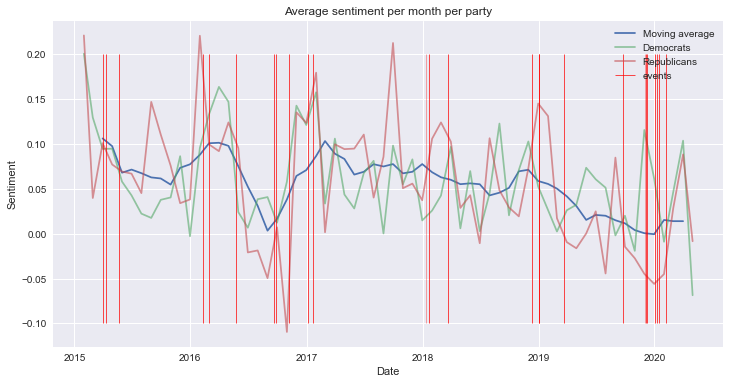

In [14]:
# Redo plot from point 1
df["date"] = pd.to_datetime(df["date"])

# Global average per month
g_all = df.set_index("date").groupby(pd.Grouper(freq="M"))["compound"].mean()
g_ma = g_all.rolling(5, center=True, closed="both").mean()
# Average per party per month
g = pd.DataFrame(df.set_index("date").groupby([pd.Grouper(freq="M"), "parties"])["compound"].mean()).reset_index("parties")
g_dem = g[g["parties"] == "Democrat"]
g_rep = g[g["parties"] == "Republican"]

# Plot average score per month and party
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(g_ma.index, g_ma, label="Moving average", alpha=1)
ax.plot(g_dem.index, g_dem["compound"], label="Democrats", alpha=0.6)
ax.plot(g_rep.index, g_rep["compound"], label="Republicans", alpha=0.6)

# add vertical lines for each event
# To check if we add weight to each event to clearly see more important ones (now random weights)
# clip=False
#ax.vlines(events["date"], ymin=-0.1, ymax=0.2, label="events", colors="red", linestyles="solid", alpha=transform_weight(events["weight"]) * 0.7, linewidth=transform_weight(events["weight"], clip=False))
# clip=True
ax.vlines(events["date"], ymin=-0.1, ymax=0.2, label="events", colors="red", linestyles="solid", alpha=transform_weight(events["weight"]) * 0.7, linewidth=transform_weight(events["weight"], clip=True))


plt.title("Average sentiment per month per party")
plt.xlabel("Date")
plt.ylabel("Sentiment")

plt.legend()

fname = f"./figures/3.5.events_average_month_party.png"
plt.savefig(fname)

plt.show() 

In [15]:
# Add interactivity with plotly

### 3.2 Most common words

In [11]:
df_rep = df[df["parties"] == "Republican"]
df_dem = df[df["parties"] == "Democrat"]

In [12]:
# Utils functions

def get_sentiment(row: pd.Series) -> pd.Series:
    """
    Compute the sentiment score of a given row
    """   
    
    row['NLTK_score'] = sia.polarity_scores(row['quotation'])
    return row

def counter(text, columnText, quantity, label):
    allWords = ' '.join([text for text in text[columnText].astype('str')])
    tokenPhrase = tokenSpace.tokenize(allWords)
    frequency = nltk.FreqDist(tokenPhrase) 
    dfFrequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())}) 
    
    dfFrequency = dfFrequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(15,3))
    ax = sns.barplot(data = dfFrequency, x = "Word", y = "Frequency", palette="deep")
    ax.set(ylabel = "Count")
    plt.xticks(rotation='horizontal')
    plt.title(f"Most common words for {label}")
    plt.show()
    
# NLTK configuration
nltk.download('vader_lexicon')
nltk.download('stopwords')
sia = SentimentIntensityAnalyzer()

# TokenSpace initialization
tokenSpace = tokenize.WhitespaceTokenizer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/olivier/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/olivier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
#remove and keep some of the stopwords
stop = stopwords.words("english")

# Add to the stopword list common words an punctuation that is present for both emotions
stop = stop + ["going", "would", "want", "get", "one", "-", "_", "[", "]"]

df_rep = df_rep.assign(quotation_clean=df_rep["quotation"].apply(lambda x: " ".join(x for x in x.split() if x not in stop)))
df_dem = df_dem.assign(quotation_clean=df_dem["quotation"].apply(lambda x: " ".join(x for x in x.split() if x not in stop)))

In [23]:
txt_dem = " ".join(df_dem["quotation_clean"].tolist())
txt_rep = " ".join(df_rep["quotation_clean"].tolist())

In [46]:
col_dem = get_single_color_func("steelblue")
col_rep = get_single_color_func("#e81b23")

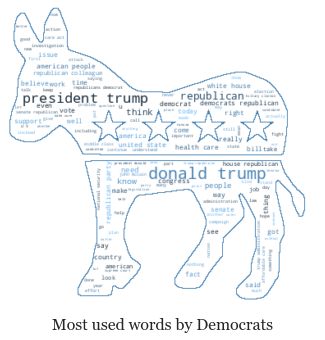

In [54]:
# Democrats
dem_mask = np.array(Image.open("./figures/dem.png"))

wc = WordCloud(background_color="white", max_words=1000, mask=dem_mask, contour_width=1, contour_color='steelblue')

# generate word cloud
wc.generate(txt_dem)

plt.imshow(wc.recolor(color_func=col_dem, random_state=42), interpolation='bilinear')
plt.axis("off")
plt.title("Most used words by Democrats", y=-0.1, fontsize=16, fontfamily="Georgia")
plt.savefig("./figures/dem_wordcloud.png", dpi=100, bbox_inches="tight")
plt.show()

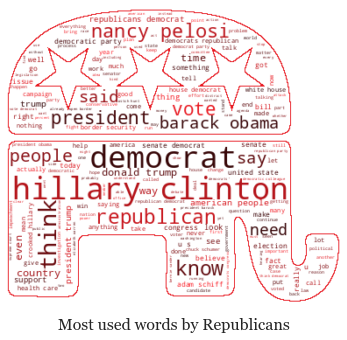

In [51]:
# Republicans
rep_mask = np.array(Image.open("./figures/rep.png"))

wc = WordCloud(background_color="white", max_words=1000, mask=rep_mask, contour_width=1, contour_color='#e81b23')

# generate word cloud
wc.generate(txt_rep)

plt.imshow(wc.recolor(color_func=col_rep, random_state=42), interpolation='bilinear')
plt.axis("off")
plt.title("Most used words by Republicans", y=-0.1, fontsize=16, fontfamily="Georgia")
plt.savefig("./figures/rep_wordcloud.png", dpi=100, bbox_inches="tight")
plt.show()